
# ARSENL Backscatter Experiments

Grant Kirchhoff
Last Updated: 02-17-2023
University of Colorado Boulder

Fit the photon arrival rate to exponentiated polynomial profiles from ARSENL INPHAMIS lidar. 

In [3]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr
import sys
import csv
from generate_sim_data import gen_sim_data, gen_rho

cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import fit_polynomial_utils as fit
import data_organize as dorg
from load_ARSENL_data import set_binwidth

## Start by loading and organizing the data in preparation for the fit.

In [6]:
# Adjust parameters here to customize run

### CONSTANTS ####
c = 2.99792458e8                      # [m/s] Speed of light
dt = 25e-12                   # [s] TCSPC resolution

### PARAMETERS ###
window_bnd = [27.5e-9, 33.5e-9]       # [s] Set boundaries for binning to exclude outliers
exclude_shots = True                     # Set TRUE to exclude data to work with smaller dataset
max_lsr_num = int(1e6)                   # If set_max_det set to FALSE, include up to certain number of laser shots
max_det_num = 2000                       # If set_max_det set to TRUE, include up to a certain number of detections
set_max_det = False                          # Set TRUE if data limiter is number of detections instead of laser shots.
deadtime = 25e-9                  # [s] Acquisition deadtime
use_stop_idx = True               # Set TRUE if you want to use up to the OD value preceding the reference OD
run_full = True                   # Set TRUE if you want to run the fits against all ODs. Otherwise, it will just load the reference data.
include_deadtime = True  # Set True to include deadtime in noise model
use_poisson_eval = True  # Set TRUE if you want to use the Poisson model for the evaluation loss
use_sim_data = True  # Set TRUE if using simulated data from 'generate_sim_data.py'

# Make sure file location is accurate
cwd = os.getcwd()
data_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\Data\Simulated'
fname = r'/sim_amp1.0E+05_nshot1.0E+07.nc'


In [7]:
# Load / generate important data structures from simulated / real datsets 
# NOTE: If user wants to test different parameters with simulated data, look into "generate_sim_data.py"

flight_time, n_shots, t_det_lst = dorg.data_organize(dt, data_dir, fname, window_bnd, 
                                                         max_lsr_num, exclude_shots=False)

if use_sim_data:
    ds = xr.open_dataset(data_dir + fname)
    laser_pulse_width = ds.laser_pulse_width.to_numpy()
    target_time = ds.target_time.to_numpy()
    target_amplitude = ds.target_amplitude.to_numpy()
    background = ds.background.to_numpy()
        
    t_sim = np.arange(window_bnd[0], window_bnd[1], dt)
    true_rho = gen_rho(target_amplitude, t_sim, target_time, laser_pulse_width, background)
    
print('Number of detections: {}'.format(len(flight_time)))
print('Number of laser shots: {}'.format(n_shots))

Number of detections: 1829
Number of laser shots: 10000000


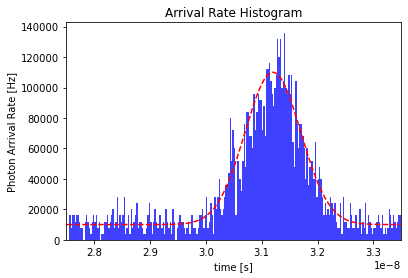

In [8]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)
bin_array = set_binwidth(window_bnd[0], window_bnd[1], dt)
if use_sim_data:
    ax.plot(t_sim, true_rho, 'r--')
n, bins = np.histogram(flight_time, bins=bin_array)
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N, align='center', width=binwidth, color='b', alpha=0.75, label='detected photons')
ax.set_title('Arrival Rate Histogram')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
ax.set_xlim([window_bnd[0], window_bnd[1]])
# plt.legend()
plt.show()

## Now applying the curve_fit routine to my data. Code designed after Matt Hayman's "Fit_TimeTag_Gaussian.ipynb" and adapted to fit to N-order exponentiated polynomial.

In [9]:
# Generate fit and validation sets
# The target is assumed to be stationary so I can split the data into halves
split_value_flight = int(len(flight_time)//2)
t_phot_fit = flight_time[:split_value_flight]
t_phot_val = flight_time[split_value_flight:]
split_value_det = int(len(t_det_lst)//2)
t_det_lst_fit = t_det_lst[:split_value_det]
t_det_lst_val = t_det_lst[split_value_det:]

# Adjust number of laser shots corresponding to fit and val sets
ratio_fit_split = len(t_phot_fit) / len(flight_time)
ratio_val_split = len(t_phot_val) / len(flight_time)
n_shots_fit = np.floor(n_shots*ratio_fit_split).astype(int)
n_shots_val = np.floor(n_shots*ratio_val_split).astype(int)

t_phot_fit_tnsr = torch.tensor(t_phot_fit.to_numpy())
t_phot_val_tnsr = torch.tensor(t_phot_val.to_numpy())

In [10]:
# optimization parameters

rel_step_lim = 1e-8  # termination criteria based on step size
max_epochs = 400     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations
intgrl_N = 10000        # Set number of steps in numerical integration

In [11]:
# I define the max/min times as fixed values. They are the upper/lower bounds of the fit.
# Time vector per shot
t_min = window_bnd[0]
t_max = window_bnd[1]
dt = dt
t_fine = np.arange(t_min, t_max, dt)

In [12]:
# Set iterate to True if you want to iterate through increasing complexity. 
# Otherwise set to False if you want to check a single polynomial order.
single_step_iter = True
M_max = 16  # Max polynomial complexity to test if iterating
M_lst = np.arange(5, 12, 1)

In [13]:
# Generate "active-ratio histogram" that adjusts the histogram proportionally according to how many bins the detector was "active vs dead"
active_ratio_hst_fit = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst_fit, n_shots_fit)
if not include_deadtime:
    active_ratio_hst_fit = torch.ones(len(active_ratio_hst_fit))  

active_ratio_hst_val = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst_val, n_shots_val)
if not include_deadtime:
    active_ratio_hst_val = torch.ones(len(active_ratio_hst_val))  
    

Time elapsed:

Order=1: 1.98 sec
Order=2: 1.39 sec
Order=3: 1.46 sec
Order=4: 1.57 sec
Order=5: 1.43 sec
Order=6: 1.40 sec
Order=7: 1.55 sec
Order=8: 1.65 sec
Order=9: 1.81 sec
Order=10: 2.73 sec
Order=11: 2.41 sec
Order=12: 2.14 sec
Order=13: 2.42 sec
Order=14: 2.95 sec
Order=15: 3.42 sec


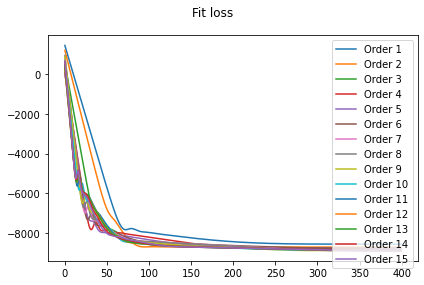

In [14]:
if single_step_iter:
    M_lst = np.arange(1, M_max, 1)
else:
    M_lst = M_lst
    M_max = max(M_lst)
    
# ax, val_loss_arr, eval_loss_arr,\
#     fit_rate_fine, coeffs = fit.optimize_fit(M_max, M_lst, t_fine, t_phot_fit_tnsr, t_phot_val_tnsr, t_phot_eval_tnsr, active_ratio_hst,
#                 active_ratio_hst_ref, n_shots_fit, n_shots_val, n_shots_eval, learning_rate, rel_step_lim, intgrl_N, max_epochs, term_persist)

iter_len = len(M_lst)
fig = plt.figure()
val_loss_arr = np.zeros(M_max+1)
coeffs = np.zeros((M_max+1, M_max+1))
fit_rate_fine = np.zeros((M_max+1, len(t_fine)))
print('Time elapsed:\n')

# Iterate through increasing polynomial complexity. 
# Compare fit w/ validation set and use minimum loss find optimal polynomial order.
for i in range(len(M_lst)):    
    # initialize for fit loop
    M = M_lst[i]  # Polynomial order  (e.g., x^2 --> M=2)
    fit_model = fit.Fit_Pulse(M, t_min, t_max)
    optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
    epoch = 0
    rel_step = 1e3*rel_step_lim
    fit_loss_lst = []
    val_loss_lst = []
    rel_step_lst = []

    init_C = np.zeros(M+1)
    for j in range(M+1):
        init_C[j] = fit_model.C[j].item()

    # set the loss function to use a Poisson point process likelihood function
    loss_fn = fit.pois_loss

    # perform fit
    start = time.time()
    t_fit_norm = fit_model.tstamp_condition(t_phot_fit_tnsr, t_min, t_max)
    t_val_norm = fit_model.tstamp_condition(t_phot_val_tnsr, t_min, t_max)
    t_intgrl = fit.cheby_poly(torch.linspace(0, 1, intgrl_N), M)
    while rel_step > rel_step_lim and epoch < max_epochs:
        fit_model.train()
        pred_fit, integral_fit = fit_model(intgrl_N, active_ratio_hst_fit, t_fit_norm, t_intgrl, cheby=True)
        loss_fit = loss_fn(pred_fit, integral_fit*n_shots_fit)  # add regularization here
        fit_loss_lst += [loss_fit.item()]

        # calculate relative step as an average over the last term_persist iterations
        if epoch == 0:
            rel_step_lst+=[1e3*rel_step_lim]
            rel_step = 1e3*rel_step_lim
        else:
            rel_step_lst+=[(fit_loss_lst[-2]-fit_loss_lst[-1])/np.abs(fit_loss_lst[-2])]
            rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

        # update estimated parameters
        loss_fit.backward()
        optimizer.step()

        # zero out the gradient for the next step
        optimizer.zero_grad()

        epoch+=1
        
    pred_mod_seg, __ = fit_model(intgrl_N, active_ratio_hst_fit, torch.tensor(t_fine), t_intgrl, cheby=False)
    fit_rate_fine[M, :] = pred_mod_seg.detach().numpy().T
    coeffs[M, 0:M+1] = fit_model.C.detach().numpy().T

    # Calculate validation loss
    # Using fit from fit set, calculate loss when applied to validation set
    pred_val, integral_val = fit_model(intgrl_N, active_ratio_hst_val, t_val_norm, t_intgrl, cheby=True)
    loss_val = loss_fn(pred_val, integral_val*n_shots_val)
    val_loss_arr[M] = loss_val
        
    end = time.time()
    print('Order={}: {:.2f} sec'.format(M, end-start))
    
    plt.plot(fit_loss_lst, label='Order {}'.format(M))

ax.set_ylabel('Loss')
ax.set_xlabel('Iterations')
plt.suptitle('Fit loss')
plt.tight_layout()
plt.legend()
plt.show()

In [15]:
for i in range(len(M_lst)):
    print('Final validation loss value for order {}: {:.2f}'.format(M_lst[i], val_loss_arr[M_lst[i]]))

Final validation loss value for order 1: -8565.42
Final validation loss value for order 2: -8733.15
Final validation loss value for order 3: -8793.30
Final validation loss value for order 4: -8814.76
Final validation loss value for order 5: -8816.06
Final validation loss value for order 6: -8864.40
Final validation loss value for order 7: -8901.31
Final validation loss value for order 8: -8901.34
Final validation loss value for order 9: -8919.26
Final validation loss value for order 10: -8923.50
Final validation loss value for order 11: -8918.52
Final validation loss value for order 12: -8918.36
Final validation loss value for order 13: -8916.56
Final validation loss value for order 14: -8920.22
Final validation loss value for order 15: -8915.87


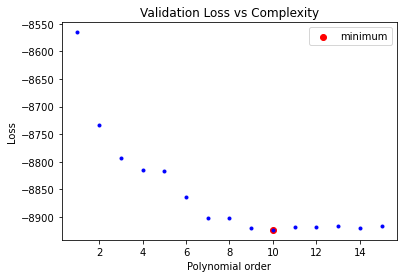

In [16]:
minx, miny = np.argmin(val_loss_arr), min(val_loss_arr)

plt.plot(M_lst, val_loss_arr[M_lst], 'b.')
plt.scatter(minx, miny,c='r', label='minimum')
plt.title('Validation Loss vs Complexity')
plt.ylabel('Loss')
plt.xlabel('Polynomial order')
plt.legend()
plt.show()

In [17]:
# Choose order to investigate
order = 10
try:
    model = coeffs[order, 0:order+1]
    for i in range(order+1):
        print('Final C{}: {:.4f}'.format(i, model[i]))
except:
    print("\nERROR: Order exceeds maximum complexity iteration value.\n")

Final C0: 5.3703
Final C1: 6.0040
Final C2: -0.6226
Final C3: -1.9644
Final C4: -0.5363
Final C5: 1.9400
Final C6: -1.0289
Final C7: -0.3758
Final C8: 1.6007
Final C9: -0.5937
Final C10: -0.4219


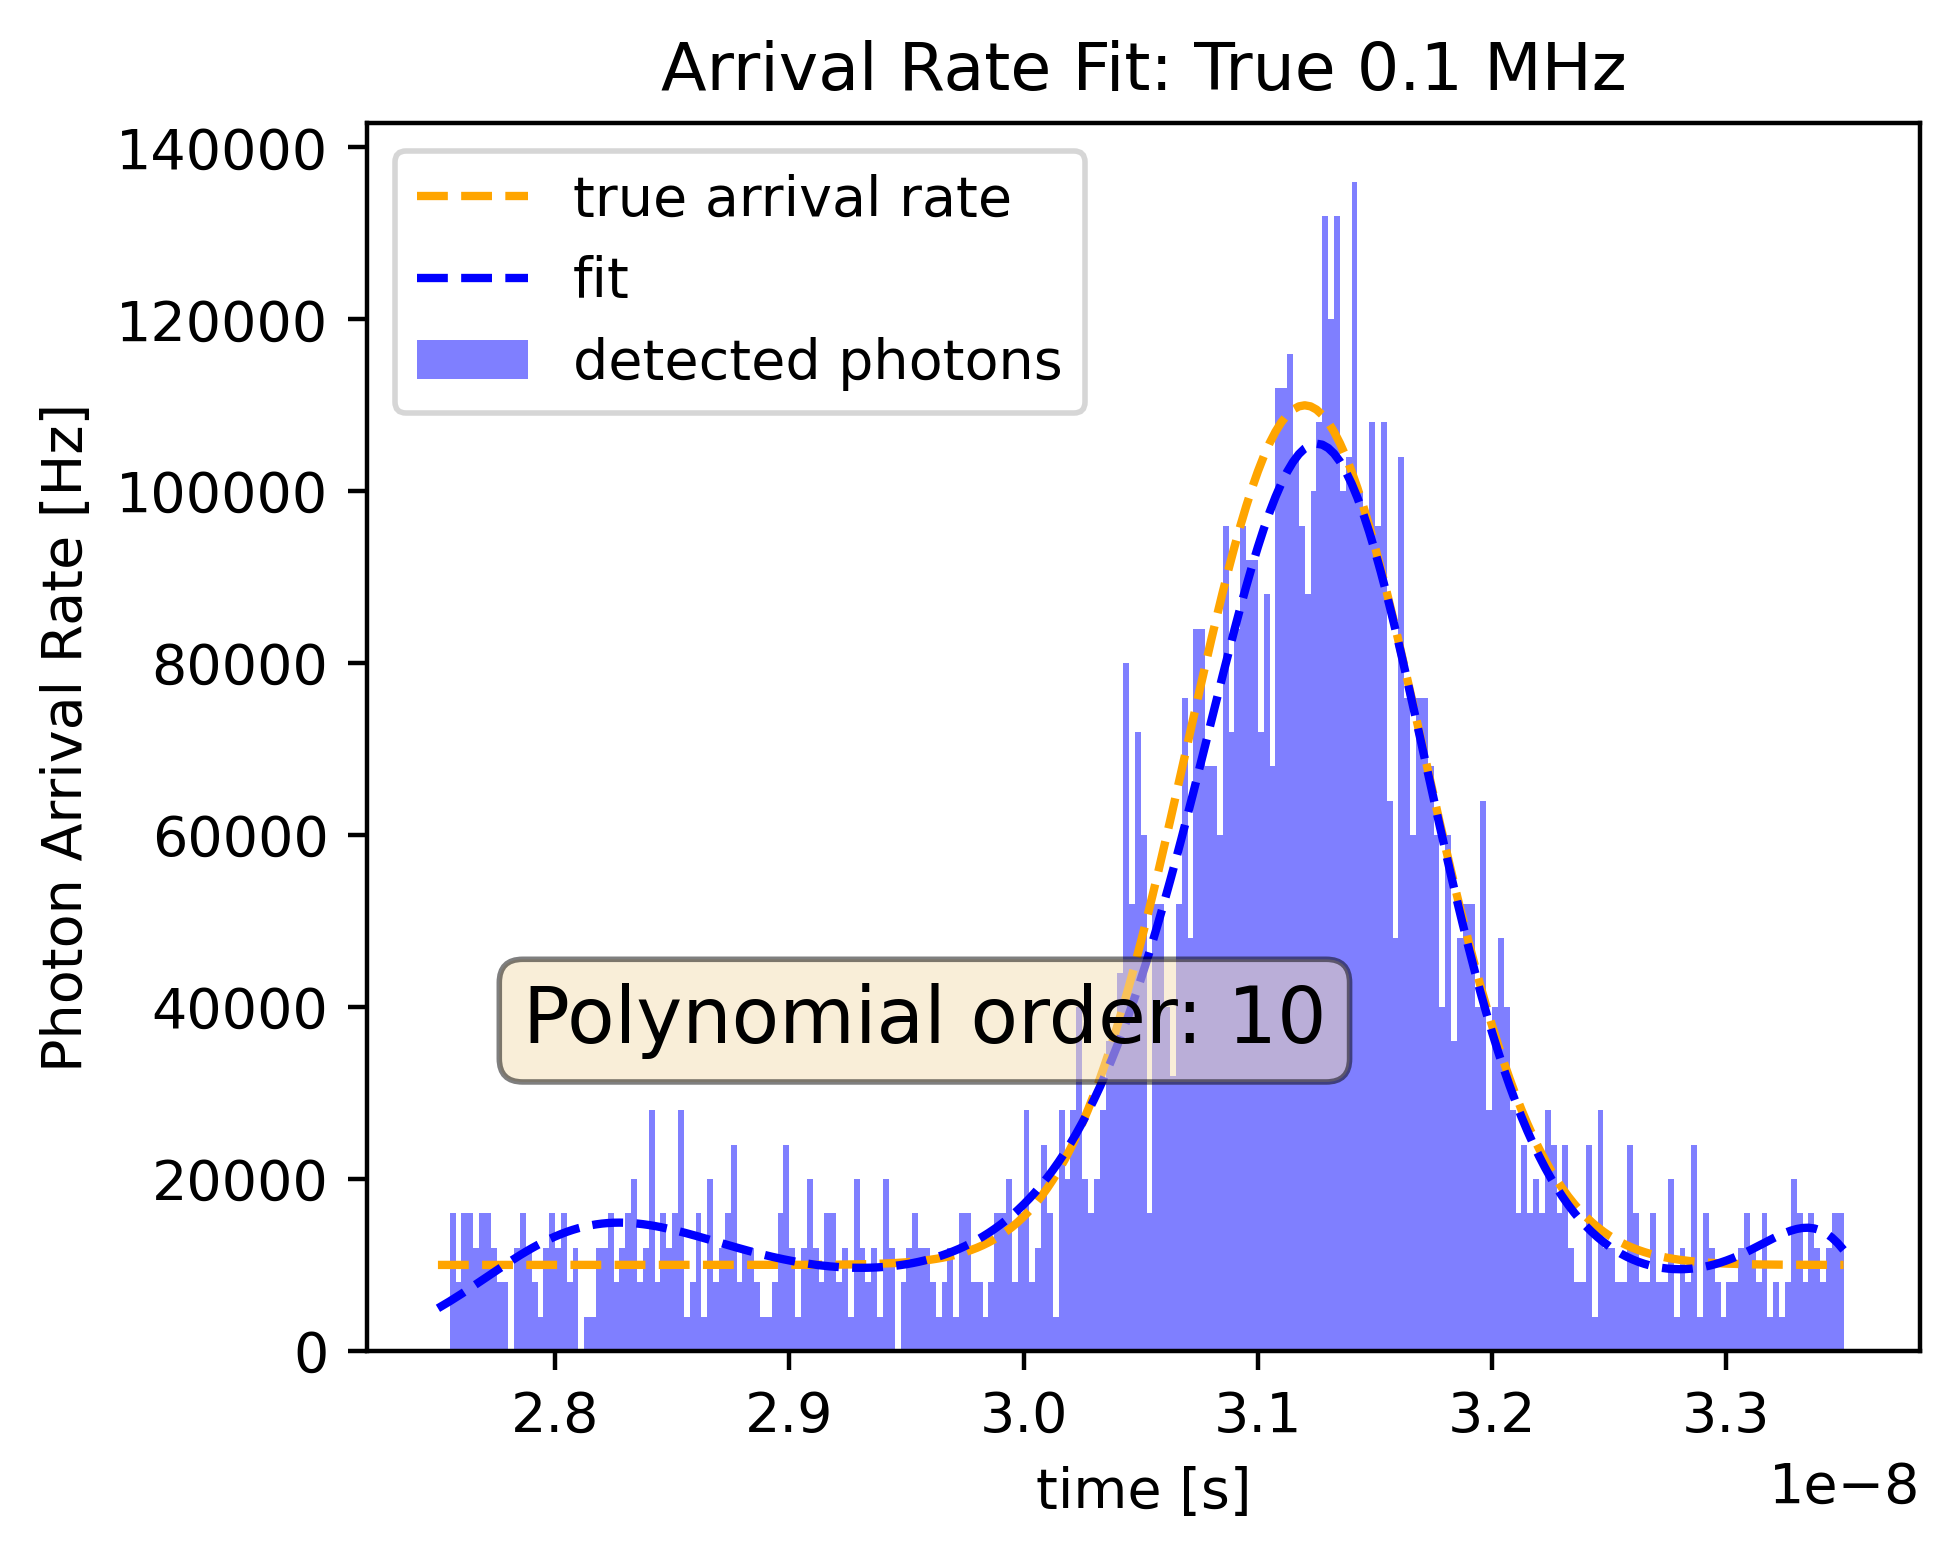

In [18]:
fig = plt.figure(figsize=(5,4), dpi=400)
ax = fig.add_subplot(111)
if use_sim_data:
#     n, bins = np.histogram(true_flight_time, bins=bin_array)
#     binwidth = np.diff(bins)[0]
#     N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
#     center = 0.5 * (bins[:-1] + bins[1:])
#     ax.bar(center, N, align='center', width=binwidth, color='orange', alpha=0.5, label='incident photons')
    ax.plot(t_fine, true_rho, '--', color='orange', label='true arrival rate')
n, bins = np.histogram(flight_time, bins=bin_array)
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N, align='center', width=binwidth, color='blue', alpha=0.5, label='detected photons')


# Arrival rate fit
t_fine = np.arange(t_min, t_max, dt)
fit_rate_seg = fit_rate_fine[order, :]
ax.plot(t_fine, fit_rate_seg, '--', color='blue', label='fit')
ax.set_title('Arrival Rate Fit')
if use_sim_data:
    ax.set_title('Arrival Rate Fit: True {} MHz'.format(target_amplitude/1e6))
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.1, 0.3, 'Polynomial order: {}'.format(order), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.legend()

save_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\Figures\SPCM_fit_performance'
# if use_sim_data:
#     save_plt_file = r'\deadtime{}rho{:.2E}MHz_use_sim_{}.png'.format(include_deadtime, target_amplitude/1e6, use_sim_data)
# else:
#     save_plt_file = r'\deadtime{}OD{}MHz_use_sim_{}.png'.format(include_deadtime, OD_val, use_sim_data)
# fig.savefig(save_dir + save_plt_file)
plt.show()


In [124]:
# save model to pickle

if use_sim_data:
    save_out = [t_fine, fit_rate_seg, true_flight_time, true_rho, flight_time, n_shots, t_min, t_max, dt]
    save_fname = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\Deadtime_Experiments\Figures\evaluation_loss\compare_deadtime_poisson\deadtime{}rho{:.2E}MHz_use_sim_{}.pkl'.format(include_deadtime, target_amplitude/1e6, use_sim_data)    
else:
    save_out = [t_fine, fit_rate_seg, flight_time, n_shots, t_min, t_max, dt]
    save_fname = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\Deadtime_Experiments\Figures\evaluation_loss\compare_deadtime_poisson\deadtime{}OD{}_use_sim_{}.pkl'.format(include_deadtime, OD_val, use_sim_data)    

pickle.dump(save_out, open(save_fname, 'wb'))



NameError: name 'true_flight_time' is not defined

### Graveyard ###

In [93]:
class NumericalIntegrator:
    def riemann(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)):
            integral += f(eval_pts[i])
        integral *= dx
        return integral

    def trapezoidal(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-1):
            integral += f(eval_pts[i]) + f(eval_pts[i+1])
        integral *= dx / 2
        return integral

    def simpsons(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-2):
            integral += f(eval_pts[i]) + 4*f(eval_pts[i+1]) + f(eval_pts[i+2])
        integral *= dx / 2 / 3
        return integral


In [ ]:
# Calculate percent error

if use_sim_data:
    err = np.abs(fit_rate_seg - true_rho) / true_rho
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    bnd = [2.9e-8, 3.3e-8]
    bnd_idx = [np.argmin(np.abs(t_fine-bnd[0])), np.argmin(np.abs(t_fine-bnd[1]))]
    ax.semilogy(t_fine[bnd_idx[0]:bnd_idx[1]], err[bnd_idx[0]:bnd_idx[1]]*100, 'r--')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('Fit error [%]')
    ax.set_title('Fit Error for Simulated Data')
    
    save_plt_file = r'\deadtime{}rho{:.1E}MHzERROR.png'.format(include_deadtime, target_amplitude/1e6)
    fig.savefig(save_dir + save_plt_file)
    plt.show()

In [ ]:
ts = np.linspace(t_min, t_max, len(active_ratio_hst_val))
abs_err = np.abs(true_rho-fit_rate_seg)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(ts, active_ratio_hst_val, label='mean active detector time')
ax.plot(t_fine, abs_err/max(abs_err), label='normalized absolute error')
ax.set_xlabel('time [s]')
ax.set_title('Active Detector Time vs Absolute Error')
plt.legend()

save_plt_file = r'\deadtime{}rho{:.1E}MHzACTIVETIME.png'.format(include_deadtime, target_amplitude/1e6)
fig.savefig(save_dir + save_plt_file)
plt.show()

In [ ]:
# Save post-processed data to netCDF

save_netCDF = False

if save_netCDF:
    processed_data = xr.Dataset(
                    data_vars=dict(
                        flight_time=flight_time.values,
                        t_fine = t_fine,
                        fit_rate_seg = fit_rate_seg,
                        order = order,
                        n_shots = n_shots
                    ),
                    attrs=dict(description="'flight_time': time tagged data; \n't_fine': fine resolution time vector per laser shot; \n'fit_rate_seg': NLL fit")
    )

    save_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\Deadtime_Experiments\Data\Postprocessed_Data'

    OD_str = fname.split('.')[4]
    fname_nc = r'\processed_{}.nc'.format(OD_str)
    processed_data.to_netcdf(save_dir+fname_nc)

In [ ]:
# Amplitude accomodation for OD: (1/10)**OD
# OD1.0: 0.1 transmission; OD0.5: 0.32 transmission; OD0.2: 0.63 transmission

OD = 3.0
OD_scale = (1/10)**OD

fig = plt.figure()
ax = fig.add_subplot(111)

# Scaled histogram
n, bins = np.histogram(flight_time, bins=20)
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N, align='center', width=binwidth, color='b', alpha=0.5)

# Arrival rate fit
t_fine = np.arange(t_min, t_max, dt)
fit_rate_seg = fit_rate_fine[order, :] / OD_scale  # [Hz] Scaling counts to "remove" OD effect
ax.plot(t_fine, fit_rate_seg, 'r--')
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.1, 0.90, 'Polynomial order: {}'.format(order), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()
